In [2]:
import pandas as pd
import random
import numpy as np
from numpy import linalg as LA


##################################################################################### COPULE DATA ###################################################################################

from scipy.io import arff
data = arff.loadarff('wq.arff')
df = pd.DataFrame(data[0])

covariables = df.iloc[:,0:14].values
response = df.iloc[:,14:30].values
positions = np.arange(1060)

from sklearn.model_selection import train_test_split

covariables_train, covariables_test, response_train, response_test,positions_train,positions_test = train_test_split(covariables, response,positions, test_size=0.33, random_state=42)
####################################################################################################################################################################################
####################################################################################################################################################################################

#Pour le training, build training data
xtrain,ytrain = covariables_train, response_train

#Pour tester build test data
xtest,ytest = covariables_test, response_test 

In [11]:

#Pour tester build test data
#xtest,ytest = covariables_test, response_test 

Train_PottsData = xtrain

#Test_PottsData = xtest

q = 20
T =1000

sigma = 1

Initial_Spin_Configuration = []

for i in range(len(Train_PottsData)):
    
    Initial_Spin_Configuration.append(random.randint(1,q))


from collections import defaultdict
# function for adding edge to graph 
graph = defaultdict(list) 


# Python program to print connected  
# components in an undirected graph
#https://www.geeksforgeeks.org/connected-components-in-an-undirected-graph/
class Graph: 
      
    # init function to declare class variables 
    def __init__(self,V): 
        self.V = V 
        self.adj = [[] for i in range(V)] 
  
    def DFSUtil(self, temp, v, visited): 
  
        # Mark the current vertex as visited 
        visited[v] = True
  
        # Store the vertex to list 
        temp.append(v) 
  
        # Repeat for all vertices adjacent 
        # to this vertex v 
        for i in self.adj[v]: 
            if visited[i] == False: 
                  
                # Update the list 
                temp = self.DFSUtil(temp, i, visited) 
        return temp 
  
    # method to add an undirected edge 
    def addEdge(self, v, w): 
        self.adj[v].append(w) 
        self.adj[w].append(v) 
  
    # Method to retrieve connected components 
    # in an undirected graph 
    def connectedComponents(self): 
        visited = [] 
        cc = [] 
        for i in range(self.V): 
            visited.append(False) 
        for v in range(self.V): 
            if visited[v] == False: 
                temp = [] 
                cc.append(self.DFSUtil(temp, v, visited)) 
        return cc
    
# This code is contributed by Abhishek Valsan    


My_Potts_Graph = Graph(len(Train_PottsData))



from collections import OrderedDict

def findneighbors(i, Train_PottsData, Initial_Spin_Configuration, k_voisins = 10):
    
    Compute_Norms  = {}
    
    for j in range(len(Train_PottsData)):
        
        bond_ij_proba = 1 - np.exp(-(1/T)*(LA.norm(Train_PottsData[i,:] - Train_PottsData[j,:]))/(sigma))
        
        bond_ij = np.random.binomial(size=1, n=1, p=bond_ij_proba) 
        
        if (i != j and Initial_Spin_Configuration[i] == Initial_Spin_Configuration[j] and bond_ij[0]==1 ):
            
            Compute_Norms[j] = LA.norm(Train_PottsData[i,:] - Train_PottsData[j,:])
                                       

    OrderedCompute_Norms = OrderedDict(sorted(Compute_Norms.items(), key=lambda x: x[1]))

    OCN_size  = len(OrderedCompute_Norms)
    
    SelectedOrderedCompute_Norms = list(OrderedCompute_Norms)#[(OCN_size -k_voisins):OCN_size ]
                                       
    return SelectedOrderedCompute_Norms      


for i in range(len(Train_PottsData)):
    
    #let's get the top neighbors of observation i
    
    Selected_Neighbors = findneighbors(i, Train_PottsData, Initial_Spin_Configuration, k_voisins = 1)
    
    for j in Selected_Neighbors:
        
        #addEdge(graph,i,j)
        My_Potts_Graph.addEdge(i,j)


Potts_Clusters = My_Potts_Graph.connectedComponents() 

print(Potts_Clusters, "DONE")


def Compute_Partition (Train_PottsData, _Spin_Configuration, T=1, sigma=1):
    
    
    """ 
    
    Given the Data and Spin Configuration, this function compute the Partition
    
    Parameters : 
    ----------
    
    PottsData: the features data, X
    
    Initial_Spin_Configuration : Initial Spin configuration for all observations
    
    T : The temperature 
    
    sigma : The bandwitch
    
    """
    
    _My_Potts_Graph = Graph(len(Train_PottsData))
    
    for i in range(len(Train_PottsData)):
        #let's get the top neighbors of observation i

        Selected_Neighbors = findneighbors(i, Train_PottsData, _Spin_Configuration, k_voisins = 1)

        for j in Selected_Neighbors:

            #addEdge(graph,i,j)
            _My_Potts_Graph.addEdge(i,j)

                
    _Potts_Clusters = _My_Potts_Graph.connectedComponents() 
    
    return _Potts_Clusters

def Partitions_Clusters_Adjustments (New_Partition, Min_Cluster_Size):
    
    Copy_New_Partition = New_Partition.copy()
    
    List_of_clusters_size = [len(cluster)>Min_Cluster_Size for cluster in New_Partition]
    
    Somme_List_of_clusters_size = np.sum(List_of_clusters_size)
    
    
    if len(List_of_clusters_size)>0 and len(Copy_New_Partition)> Somme_List_of_clusters_size: 
        
        Position_Cluster_To_be_adjusted = List_of_clusters_size.index(0) 
        
        
        
    
    
    return adjusted_Partition


###Some supplementaries Code to adjust the clustering

import numpy as np
from numpy import linalg as LA

def ChangePartition(Partition, min_size):

    MyPartition = Partition.copy()
    
    max_iter = len(MyPartition)
    
    SearchCluster = [len(Cluster) > min_size for Cluster in MyPartition]
    
    if 0 in SearchCluster:
        ChooseTheFirstCluster = SearchCluster.index(0)

        distancelist = []
        
        for _i in range(max_iter):
                
                if _i!= ChooseTheFirstCluster:
                
                   distancelist.append(compute_distance(MyPartition[_i],MyPartition[ChooseTheFirstCluster]))
        
                else:
                     distancelist.append(0)   
                                       
        distancelist[ChooseTheFirstCluster] =  np.sum(distancelist)
                                       
        Cluster_To_MergeWith = np.argmin(distancelist)
                                       
        MyPartition[Cluster_To_MergeWith] = MyPartition[Cluster_To_MergeWith]+MyPartition[ChooseTheFirstCluster]
                                       
        del MyPartition[ChooseTheFirstCluster]
                                       
    return MyPartition                                   

def compute_distance(cluster1,cluster2):

    cluster_1 = cluster1.copy()
    cluster_2 = cluster2.copy()
    
    
    all_distances= []
    
    
    for j in cluster_1:
        
        all_distances.extend([LA.norm(Train_PottsData[j,:] - Train_PottsData[k,:]) for k in cluster_2])
        
        
    return float(np.min(all_distances))

def AdjustPartition(GeneratedPartition, min_cluster_size):
    
    NewPartition0 = GeneratedPartition

    NewPartition1 = ChangePartition(GeneratedPartition, 1)


    while NewPartition1 != NewPartition0:

          NewPartition0 = NewPartition1
            
          #Nous souhaitons ajuster les partitions à une taille de cluster minimum==5  
          NewPartitionAdj = ChangePartition(NewPartition0, min_cluster_size) 

          NewPartition1 = NewPartitionAdj

    return NewPartition1

###########
def Potts_Random_Partition (Train_PottsData, Initial_Partition = Potts_Clusters, Number_of_Random_Partitions = 1000) : 
    
    
    """ 
    
    This function generates _Random_Partitions for a given initial Potts_Clusters
    
    Parameters
    ----------
    
    Initial_Partition : A given initial (random partition) in defaultdict(list) format
    
    Number_of_Random_Partitions: Number of expected random partitions, must be greater than 0 preferably
    
    
    Return    
    ------
    
    Full_Observations_Spin_Configuration : A full list of spin configuration for each generated partition 
    
    Full_Partition_Sets : A full list of all generated partitions
    
    
    """
    
    Full_Observations_Spin_Configuration = defaultdict(list) 
    
    Full_Partition_Sets = defaultdict(list) 
    
    Actual_Partition = Initial_Partition
    
    k = 0
    
    while k < (Number_of_Random_Partitions + 1):
        
        
            #Create the Clustter Component spin configuration 

            _Cluster_Spin_Configuration = []

            for h in range(len(Actual_Partition)):

                _Cluster_Spin_Configuration.append(random.randint(1,q))

            #Find observation spin configuration

            Observations_Spin_Configuration = []

            for observation in range(len(Train_PottsData)):

                Observation_Cluster_index = [ int(observation in Cluster) for Cluster in  Actual_Partition ].index(1)

                Observations_Spin_Configuration.append(_Cluster_Spin_Configuration[Observation_Cluster_index])
            
            
            Full_Observations_Spin_Configuration[k] = Observations_Spin_Configuration
            
            
            New_Partition = Compute_Partition (Train_PottsData, Observations_Spin_Configuration, T=1, sigma=1)

            #print(New_Partition)
            
            AdjustedPartition = AdjustPartition(New_Partition,2)
            
            List_of_clusters_size = [len(cluster) for cluster in AdjustedPartition]
            
            if  int(np.min(List_of_clusters_size)) >= 1 : 
                
                                
                Full_Partition_Sets[k] = AdjustedPartition

                k = k + 1
                print("We are at step: %i"%k)
                print("Clusters Size of Current Partition", List_of_clusters_size)
                print("Partition is:", AdjustedPartition)
            Actual_Partition = AdjustedPartition
            
    return Full_Partition_Sets, Full_Observations_Spin_Configuration


import time
start_time = time.time()

NRP = 50

Partitions_Sets,Spin_Configuration_Sets = Potts_Random_Partition (Train_PottsData, Initial_Partition= Potts_Clusters, Number_of_Random_Partitions = NRP)

print("%i Partitions generated-- %s seconds ---DONE!" % (NRP, time.time() - start_time))

import pickle
output = open('wq_50_Partitions_constraints_2_Sets.pkl', 'wb')
pickle.dump(Partitions_Sets, output)
output.close()


[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11, 325], [12], [13], [14], [15], [16], [17, 425, 698], [18, 577], [19], [20], [21], [22], [23, 342], [24], [25], [26, 355], [27], [28], [29, 360, 703], [30, 47], [31], [32], [33, 202, 268], [34], [35], [36], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [48, 379, 463], [49], [50], [51], [52], [53], [54], [55], [56, 405], [57, 481], [58], [59], [60], [61], [62], [63], [64], [65], [66], [67], [68], [69], [70], [71], [72], [73], [74], [75], [76], [77, 255, 603], [78], [79, 297, 333], [80, 206], [81], [82], [83, 671, 419, 491], [84], [85], [86], [87], [88], [89], [90], [91], [92, 438], [93], [94], [95], [96], [97], [98], [99], [100, 194], [101], [102], [103], [104], [105], [106], [107], [108], [109], [110, 600], [111], [112], [113], [114], [115], [116], [117, 518], [118, 678], [119], [120], [121], [122], [123], [124], [125], [126], [127], [128, 366], [129], [130], [131], [132, 376], [133, 617], [134], [135], [136], [1

We are at step: 2
Clusters Size of Current Partition [12, 8, 10, 15, 4, 33, 8, 5, 6, 6, 6, 6, 11, 4, 10, 3, 3, 4, 5, 5, 10, 5, 9, 5, 13, 4, 4, 8, 4, 3, 14, 9, 7, 5, 9, 5, 8, 6, 7, 4, 4, 6, 7, 7, 5, 3, 11, 4, 6, 7, 6, 4, 4, 3, 4, 4, 5, 4, 4, 3, 3, 6, 5, 4, 7, 7, 9, 10, 3, 7, 5, 3, 3, 3, 6, 3, 5, 3, 4, 3, 12, 5, 4, 5, 3, 4, 5, 7, 5, 4, 3, 7, 6, 10, 4, 5, 3, 7, 5, 9, 14, 3, 6, 6, 3, 5, 3, 6, 8, 4, 3, 4, 5, 4, 3, 4, 5, 3, 5]
Partition is: [[4, 532, 627, 16, 221, 150, 236, 106, 288, 466, 534, 694], [7, 251, 489, 581, 22, 582, 151, 173], [14, 417, 70, 71, 217, 131, 203, 318, 384, 661], [17, 76, 333, 152, 365, 431, 15, 79, 102, 192, 349, 602, 682, 578, 690], [20, 479, 616, 448], [26, 657, 78, 390, 336, 427, 463, 48, 648, 229, 357, 183, 260, 683, 597, 8, 27, 53, 148, 153, 169, 184, 250, 276, 308, 322, 462, 664, 671, 684, 359, 698, 699], [28, 606, 693, 118, 637, 324, 689, 515], [39, 596, 38, 174, 496], [46, 360, 401, 424, 575, 697], [47, 518, 433, 329, 549, 420], [50, 228, 361, 1, 44, 691], [58

We are at step: 4
Clusters Size of Current Partition [12, 8, 11, 3, 6, 5, 10, 6, 5, 4, 11, 13, 4, 14, 9, 6, 8, 8, 11, 5, 5, 4, 5, 14, 7, 13, 7, 6, 3, 3, 5, 16, 3, 6, 7, 5, 5, 7, 4, 3, 3, 3, 5, 5, 3, 6, 7, 6, 5, 10, 12, 6, 11, 7, 5, 5, 4, 3, 5, 3, 4, 4, 4, 10, 3, 6, 4, 5, 6, 6, 3, 3, 8, 3, 4, 3, 12, 5, 5, 3, 5, 3, 6, 5, 5, 5, 5, 5, 5, 5, 11, 4, 3, 5, 4, 3, 3, 3, 6, 5, 8, 4, 5, 12, 3, 3, 5, 5, 8, 3, 3, 3, 3, 6, 4, 5, 5, 3, 3, 3, 3, 6, 5, 4]
Partition is: [[12, 354, 668, 228, 213, 140, 170, 84, 314, 130, 449, 589], [17, 691, 15, 50, 102, 192, 133, 401], [19, 269, 274, 673, 85, 650, 91, 588, 159, 267, 620], [39, 38, 567], [43, 128, 109, 394, 472, 378], [45, 679, 60, 134, 522], [56, 694, 129, 301, 398, 179, 473, 571, 678, 695], [58, 47, 356, 271, 664, 183], [59, 126, 428, 585, 379], [64, 345, 37, 40], [65, 683, 202, 681, 196, 322, 456, 511, 607, 105, 688], [71, 153, 390, 613, 199, 661, 131, 70, 169, 344, 597, 184, 671], [79, 395, 553, 125], [94, 542, 342, 625, 685, 31, 215, 245, 302, 343, 5

We are at step: 6
Clusters Size of Current Partition [3, 12, 7, 3, 10, 12, 4, 5, 5, 11, 6, 9, 10, 6, 6, 10, 3, 5, 5, 9, 8, 6, 3, 3, 4, 5, 4, 8, 8, 4, 4, 6, 4, 4, 4, 8, 6, 5, 4, 15, 6, 4, 4, 3, 4, 7, 4, 5, 3, 4, 11, 5, 8, 5, 3, 3, 10, 8, 6, 4, 7, 4, 3, 4, 6, 4, 6, 4, 3, 4, 3, 11, 3, 9, 6, 3, 6, 3, 3, 6, 3, 3, 3, 8, 3, 3, 3, 4, 5, 5, 4, 6, 5, 5, 5, 4, 4, 3, 5, 5, 3, 3, 4, 3, 6, 5, 5, 4, 4, 5, 3, 3, 3, 7, 5, 3, 4, 6, 3, 3, 3, 3, 5, 11, 3, 3, 3, 4, 3, 4, 4, 4, 3, 3, 5, 3, 4, 6, 9]
Partition is: [[1, 427, 254], [3, 466, 323, 182, 350, 229, 236, 462, 106, 325, 529, 627], [6, 357, 70, 131, 203, 384, 661], [8, 197, 486], [11, 500, 79, 17, 82, 102, 294, 132, 401, 471], [21, 520, 24, 351, 34, 210, 224, 433, 480, 620, 91, 643], [35, 281, 677, 391], [36, 637, 28, 324, 498], [44, 336, 399, 156, 166], [56, 362, 621, 157, 268, 319, 398, 179, 507, 609, 185], [58, 344, 53, 356, 271, 582], [66, 385, 67, 405, 457, 107, 467, 535, 138], [90, 108, 335, 103, 222, 380, 365, 634, 658, 30], [101, 526, 597, 184,

We are at step: 8
Clusters Size of Current Partition [8, 11, 14, 14, 6, 5, 13, 7, 5, 8, 7, 4, 7, 6, 8, 5, 5, 9, 15, 7, 7, 9, 6, 6, 4, 14, 10, 3, 3, 8, 4, 3, 8, 8, 4, 4, 6, 3, 5, 4, 4, 9, 8, 3, 5, 7, 10, 4, 6, 5, 7, 3, 5, 4, 4, 4, 6, 4, 6, 4, 4, 4, 3, 6, 10, 7, 7, 4, 5, 5, 3, 12, 6, 3, 3, 9, 5, 3, 3, 5, 3, 8, 3, 5, 7, 7, 3, 3, 3, 3, 3, 8, 3, 7, 6, 6, 5, 7, 4, 3, 3, 6, 3, 6, 9, 6, 3, 4, 5, 5, 3, 4, 3, 4, 5, 3, 6, 4, 4, 3, 3, 4, 3, 5, 3, 3, 5]
Partition is: [[1, 296, 681, 211, 490, 214, 353, 456], [6, 194, 376, 434, 221, 60, 134, 150, 165, 505, 534], [10, 244, 621, 240, 158, 72, 239, 397, 437, 499, 686, 119, 708, 270], [11, 418, 170, 688, 82, 84, 132, 216, 320, 345, 37, 501, 697, 360], [12, 515, 493, 243, 234, 568], [23, 90, 506, 275, 162], [34, 91, 291, 88, 709, 407, 549, 420, 560, 62, 619, 620, 635], [40, 460, 306, 521, 543, 642, 191], [59, 334, 574, 269, 310], [79, 343, 17, 15, 192, 133, 401, 633], [98, 514, 65, 263, 332, 454, 622], [102, 375, 667, 445], [104, 680, 13, 285, 142, 357, 7

We are at step: 10
Clusters Size of Current Partition [14, 6, 7, 3, 5, 14, 9, 13, 9, 7, 10, 9, 7, 10, 9, 4, 9, 6, 9, 4, 11, 6, 5, 9, 4, 9, 4, 4, 3, 8, 5, 4, 8, 6, 3, 5, 5, 6, 7, 6, 6, 4, 6, 8, 6, 8, 3, 4, 3, 8, 5, 8, 3, 8, 6, 5, 4, 3, 4, 3, 4, 4, 7, 7, 10, 10, 5, 6, 5, 4, 10, 4, 5, 6, 4, 3, 5, 6, 5, 3, 8, 9, 3, 4, 5, 5, 4, 7, 3, 3, 8, 5, 7, 4, 5, 7, 4, 5, 4, 4, 4, 3, 5, 8, 3, 4, 5, 3, 6, 6, 6, 3, 5, 4, 5, 4, 4, 3, 7, 13, 5]
Partition is: [[6, 567, 183, 628, 623, 595, 303, 83, 190, 385, 663, 664, 669, 502], [13, 387, 442, 104, 403, 307], [18, 213, 259, 702, 116, 600, 151], [22, 629, 189], [25, 542, 106, 249, 287], [31, 215, 354, 127, 276, 432, 476, 182, 20, 48, 8, 258, 205, 311], [41, 12, 123, 170, 84, 314, 130, 589, 625], [42, 671, 450, 655, 668, 177, 140, 217, 390, 169, 597, 184, 601], [56, 679, 285, 254, 357, 398, 179, 695, 706], [68, 564, 236, 111, 288, 547, 627], [74, 581, 199, 414, 293, 380, 201, 297, 475, 608], [76, 486, 466, 666, 681, 456, 490, 214, 690], [78, 444, 27, 148, 71, 

We are at step: 12
Clusters Size of Current Partition [7, 22, 6, 7, 4, 42, 3, 9, 13, 7, 10, 3, 6, 11, 5, 11, 7, 5, 4, 5, 6, 10, 4, 3, 7, 5, 8, 4, 4, 9, 4, 6, 3, 9, 7, 8, 3, 4, 6, 9, 6, 4, 9, 3, 12, 10, 6, 6, 5, 9, 4, 4, 12, 6, 3, 6, 5, 3, 3, 4, 7, 4, 3, 5, 5, 4, 5, 4, 7, 3, 3, 5, 3, 4, 5, 4, 6, 3, 3, 5, 5, 4, 6, 4, 5, 3, 5, 4, 3, 4, 4, 3, 3, 3, 6, 3, 7, 11, 3, 5, 3, 4, 3, 6, 3, 3, 3, 3, 4, 6, 4, 5, 4, 3, 3, 5, 3, 10, 3, 4, 3, 4, 6, 3, 4, 3]
Partition is: [[14, 506, 141, 312, 175, 705, 500], [15, 566, 411, 285, 428, 300, 104, 13, 115, 142, 192, 133, 254, 313, 113, 386, 558, 446, 586, 630, 659, 706], [18, 56, 96, 116, 409, 4], [26, 55, 395, 93, 125, 250, 604], [27, 581, 315, 552], [36, 289, 550, 276, 544, 187, 117, 641, 684, 326, 514, 70, 203, 429, 483, 48, 8, 61, 65, 131, 195, 251, 22, 263, 196, 278, 359, 308, 332, 364, 369, 384, 524, 530, 75, 539, 226, 599, 338, 647, 2, 661], [58, 35, 356], [76, 449, 559, 602, 43, 480, 228, 44, 690], [80, 509, 189, 536, 380, 708, 152, 230, 270, 297, 74

We are at step: 14
Clusters Size of Current Partition [23, 6, 9, 13, 3, 6, 6, 6, 9, 9, 16, 13, 5, 7, 9, 7, 9, 9, 6, 5, 5, 9, 5, 10, 3, 3, 5, 9, 5, 5, 9, 7, 7, 8, 3, 5, 3, 7, 9, 4, 8, 6, 3, 6, 4, 3, 3, 3, 3, 4, 5, 4, 6, 6, 4, 7, 3, 3, 4, 6, 3, 4, 3, 3, 9, 5, 5, 4, 5, 4, 5, 3, 5, 3, 3, 5, 5, 3, 6, 7, 6, 4, 4, 7, 3, 6, 4, 5, 4, 5, 4, 3, 6, 6, 11, 6, 5, 3, 3, 4, 3, 4, 3, 5, 8, 6, 10, 3, 4, 3, 4, 4, 5, 3, 3, 7, 7, 3, 4, 4, 4, 4, 4, 3, 3, 4, 4, 8, 6]
Partition is: [[0, 208, 31, 126, 259, 11, 39, 38, 82, 132, 193, 215, 216, 258, 205, 320, 439, 282, 574, 421, 591, 477, 641], [1, 122, 460, 52, 642, 191], [2, 217, 671, 281, 606, 689, 391, 601, 655], [7, 690, 388, 63, 610, 42, 232, 309, 402, 177, 450, 476, 576], [8, 292, 254], [10, 680, 324, 389, 397, 541], [49, 559, 674, 43, 656, 557], [60, 588, 19, 134, 673, 650], [61, 377, 666, 144, 90, 187, 452, 528, 544], [62, 621, 385, 302, 94, 298, 6, 343, 633], [73, 221, 295, 101, 189, 504, 99, 692, 150, 534, 483, 562, 577, 572, 679, 694], [74, 147, 590, 

We are at step: 16
Clusters Size of Current Partition [5, 5, 4, 6, 12, 5, 18, 9, 4, 9, 6, 6, 5, 5, 4, 3, 7, 5, 3, 6, 6, 8, 6, 8, 3, 7, 9, 6, 4, 11, 7, 10, 5, 9, 8, 4, 9, 3, 4, 10, 3, 4, 7, 14, 4, 3, 6, 3, 6, 6, 5, 3, 8, 4, 7, 8, 13, 4, 8, 4, 5, 3, 3, 4, 7, 12, 5, 5, 6, 7, 4, 3, 3, 4, 5, 9, 6, 6, 3, 14, 4, 5, 6, 12, 5, 6, 3, 3, 3, 5, 4, 5, 3, 3, 9, 3, 4, 3, 3, 3, 6, 14, 3, 3, 3, 6, 5, 3, 3, 4, 4, 5, 6, 8, 4, 4, 4, 4, 3, 5, 3, 3, 3, 5, 6, 3]
Partition is: [[4, 150, 466, 142, 562], [7, 329, 232, 417, 318], [9, 264, 636, 124], [17, 492, 270, 557, 401, 469], [18, 236, 296, 549, 282, 106, 116, 211, 353, 409, 627, 635], [40, 153, 330, 544, 657], [51, 63, 297, 479, 528, 455, 564, 157, 74, 189, 249, 25, 287, 309, 182, 507, 547, 677], [54, 551, 512, 610, 96, 388, 428, 476, 576], [56, 664, 467, 183], [60, 151, 587, 359, 192, 121, 134, 581, 684], [75, 407, 132, 11, 82, 216], [79, 566, 165, 115, 630, 659], [85, 384, 354, 526, 267], [92, 49, 674, 273, 656], [93, 123, 41, 423], [102, 405, 67], [104, 

We are at step: 18
Clusters Size of Current Partition [5, 21, 13, 16, 7, 12, 7, 9, 8, 6, 5, 3, 6, 4, 5, 5, 5, 10, 7, 8, 8, 6, 3, 10, 9, 7, 7, 7, 5, 7, 11, 3, 5, 5, 8, 6, 4, 5, 9, 5, 8, 6, 4, 3, 3, 6, 7, 5, 6, 5, 4, 10, 4, 3, 3, 3, 4, 6, 4, 3, 6, 3, 4, 5, 4, 10, 4, 4, 5, 4, 5, 4, 3, 6, 3, 3, 5, 3, 7, 5, 4, 4, 5, 5, 3, 5, 5, 3, 4, 4, 3, 5, 3, 8, 8, 3, 4, 8, 3, 4, 3, 5, 8, 3, 5, 11, 3, 5, 6, 3, 6, 3, 3, 6, 5, 7, 3, 5, 4, 3, 4, 4, 4, 7, 5, 4, 12]
Partition is: [[1, 466, 554, 372, 114], [10, 273, 299, 681, 649, 564, 189, 249, 25, 287, 348, 397, 456, 464, 468, 490, 214, 573, 580, 674, 92], [17, 37, 40, 369, 15, 79, 102, 192, 401, 471, 294, 501, 537], [18, 142, 308, 267, 442, 384, 85, 246, 57, 387, 204, 403, 307, 409, 4, 412], [29, 447, 38, 39, 64, 219, 383], [62, 626, 67, 499, 518, 126, 133, 405, 199, 353, 422, 526], [63, 181, 576, 309, 182, 402, 177], [76, 509, 519, 81, 341, 459, 470, 259, 602], [91, 288, 627, 620, 605, 236, 106, 367], [93, 230, 591, 423, 587, 121], [100, 665, 80, 152, 376]

We are at step: 20
Clusters Size of Current Partition [6, 16, 5, 8, 7, 8, 11, 5, 8, 5, 9, 6, 6, 8, 8, 9, 9, 7, 12, 5, 7, 3, 8, 5, 6, 5, 6, 4, 7, 7, 4, 7, 10, 7, 4, 3, 4, 4, 5, 6, 8, 10, 4, 5, 3, 7, 9, 8, 3, 3, 3, 7, 5, 4, 4, 5, 5, 4, 7, 4, 10, 3, 3, 3, 4, 7, 4, 3, 3, 6, 4, 6, 3, 6, 3, 8, 4, 5, 3, 3, 5, 5, 5, 5, 7, 6, 6, 5, 5, 8, 6, 5, 4, 5, 5, 6, 6, 4, 4, 4, 4, 3, 3, 4, 3, 6, 5, 15, 3, 3, 3, 5, 5, 3, 8, 13, 6, 3, 3, 5, 3, 3, 3, 3, 3, 3, 5, 3, 6]
Partition is: [[3, 325, 555, 323, 410, 425], [19, 559, 360, 128, 52, 43, 122, 292, 697, 354, 638, 394, 495, 584, 358, 644], [28, 409, 4, 18, 504], [29, 233, 653, 499, 149, 652, 516, 231], [32, 501, 37, 502, 384, 588, 669], [36, 225, 339, 33, 369, 426, 498, 676], [39, 310, 352, 38, 123, 41, 147, 77, 211, 262, 621], [46, 136, 401, 424, 575], [51, 450, 486, 483, 42, 197, 419, 440], [61, 526, 271, 187, 544], [63, 64, 179, 219, 309, 182, 402, 177, 695], [67, 188, 436, 405, 563, 88], [68, 276, 48, 8, 550, 546], [69, 247, 70, 131, 491, 256, 677, 661],

We are at step: 22
Clusters Size of Current Partition [4, 3, 6, 8, 12, 7, 7, 11, 9, 5, 9, 7, 3, 3, 8, 7, 11, 3, 9, 4, 10, 9, 4, 9, 11, 7, 13, 6, 5, 4, 20, 4, 16, 8, 3, 10, 8, 13, 3, 8, 13, 11, 3, 5, 7, 17, 7, 4, 6, 10, 5, 5, 8, 15, 7, 3, 4, 7, 9, 5, 3, 5, 3, 5, 5, 3, 6, 3, 4, 4, 5, 3, 5, 4, 3, 6, 5, 4, 3, 5, 7, 3, 5, 4, 3, 8, 5, 4, 3, 4, 7, 4, 5, 3, 3, 4, 8, 3, 10, 3, 4, 3, 3, 6, 4, 7, 3, 5, 3, 6, 4, 3, 5, 5, 5, 3, 3]
Partition is: [[4, 553, 250, 638], [6, 266, 118], [11, 589, 287, 82, 132, 216], [13, 62, 191, 168, 104, 285, 142, 357], [17, 354, 688, 528, 274, 15, 79, 192, 345, 37, 401, 501], [18, 33, 557, 116, 409, 426, 676], [21, 395, 102, 125, 210, 351, 643], [29, 87, 391, 137, 253, 256, 247, 278, 281, 414, 201], [40, 133, 275, 162, 23, 346, 485, 590, 667], [42, 309, 560, 182, 619], [56, 537, 399, 585, 32, 379, 101, 156, 166], [58, 505, 592, 271, 356, 430, 620], [75, 410, 567], [77, 141, 381], [78, 227, 27, 148, 71, 279, 598, 699], [92, 157, 674, 273, 507, 609, 185], [112, 336, 650,

We are at step: 24
Clusters Size of Current Partition [6, 24, 16, 10, 30, 5, 3, 4, 4, 6, 6, 6, 7, 6, 9, 12, 6, 9, 12, 6, 6, 8, 6, 16, 7, 6, 5, 7, 5, 5, 8, 9, 6, 3, 6, 5, 3, 11, 3, 13, 6, 3, 9, 4, 6, 4, 3, 3, 7, 5, 4, 8, 5, 3, 7, 4, 3, 11, 6, 4, 4, 5, 5, 5, 3, 5, 3, 4, 5, 15, 7, 3, 4, 3, 5, 4, 3, 9, 5, 3, 5, 5, 6, 4, 3, 3, 6, 3, 3, 5, 4, 4, 3, 4, 11, 3, 10, 3, 3, 4, 4, 5, 3, 6, 8, 4, 4, 4, 4, 3, 3, 3, 4, 4, 4, 3, 3, 6, 6, 7]
Partition is: [[14, 706, 510, 619, 513, 493], [15, 44, 347, 247, 362, 451, 650, 561, 148, 350, 550, 71, 78, 27, 256, 268, 278, 414, 201, 529, 533, 639, 612, 699], [16, 102, 30, 525, 155, 209, 221, 150, 404, 534, 483, 562, 616, 448, 658, 694], [19, 375, 508, 344, 432, 445, 461, 582, 588, 613], [25, 153, 465, 370, 629, 115, 657, 103, 112, 120, 222, 249, 286, 287, 316, 335, 348, 299, 365, 515, 566, 531, 558, 446, 580, 35, 592, 634, 630, 659], [26, 40, 546, 250, 260], [34, 99, 467], [37, 133, 301, 473], [39, 48, 8, 38], [41, 450, 248, 123, 290, 416], [42, 460, 288, 1, 6

We are at step: 26
Clusters Size of Current Partition [6, 36, 19, 4, 11, 4, 7, 15, 5, 20, 5, 13, 8, 7, 4, 5, 5, 9, 3, 8, 4, 7, 3, 4, 7, 6, 6, 8, 3, 21, 5, 14, 7, 4, 3, 5, 3, 3, 7, 6, 3, 6, 7, 6, 13, 3, 5, 5, 3, 5, 4, 3, 4, 5, 7, 4, 4, 3, 6, 4, 7, 3, 7, 8, 6, 5, 7, 5, 3, 6, 5, 4, 6, 6, 3, 3, 5, 6, 4, 3, 5, 7, 5, 5, 5, 6, 5, 4, 8, 3, 6, 8, 3, 4, 6, 5, 4, 5, 3, 6, 4, 9, 3, 6, 5, 6, 3, 6, 8, 3, 4, 4, 3, 3, 3, 4, 5, 3, 3]
Partition is: [[1, 708, 239, 270, 559, 43], [3, 225, 305, 666, 364, 139, 358, 425, 92, 145, 263, 195, 703, 251, 332, 144, 10, 22, 196, 243, 234, 255, 266, 384, 323, 397, 410, 498, 36, 520, 34, 527, 528, 611, 654, 86], [16, 146, 570, 151, 5, 7, 54, 342, 245, 417, 318, 455, 479, 538, 453, 581, 624, 702, 600], [17, 680, 15, 102], [28, 354, 620, 167, 283, 324, 262, 356, 9, 58, 637], [38, 695, 401, 39], [42, 309, 171, 182, 261, 443, 393], [47, 267, 82, 152, 132, 361, 115, 11, 85, 216, 230, 286, 433, 659, 566], [56, 154, 12, 398, 179], [61, 657, 622, 153, 79, 233, 641, 630, 352,

We are at step: 28
Clusters Size of Current Partition [12, 8, 8, 11, 9, 6, 4, 6, 9, 13, 10, 16, 12, 4, 7, 10, 3, 5, 6, 7, 5, 11, 5, 5, 7, 4, 3, 3, 3, 13, 10, 16, 4, 5, 13, 10, 4, 6, 3, 8, 6, 7, 6, 6, 3, 3, 5, 4, 4, 6, 9, 3, 4, 6, 5, 8, 3, 7, 3, 4, 4, 3, 6, 7, 5, 5, 3, 7, 9, 4, 4, 3, 5, 5, 4, 4, 3, 5, 3, 3, 3, 5, 6, 5, 3, 5, 3, 3, 5, 8, 6, 4, 5, 6, 4, 5, 5, 3, 6, 4, 6, 3, 3, 3, 4, 3, 8, 16, 3, 3, 4, 9, 6, 8, 5, 4, 3, 3, 3, 3, 4, 4, 4, 6]
Partition is: [[6, 509, 114, 64, 198, 206, 178, 219, 257, 341, 372, 487], [18, 405, 621, 515, 67, 116, 409, 4], [26, 456, 260, 250, 432, 681, 490, 698], [28, 359, 431, 492, 49, 112, 469, 637, 656, 557, 684], [43, 488, 463, 137, 87, 253, 510, 493, 559], [53, 484, 689, 327, 336, 606], [54, 231, 332, 428], [56, 299, 163, 348, 580, 35], [68, 306, 224, 562, 24, 388, 433, 521, 543], [78, 522, 100, 529, 324, 350, 27, 148, 71, 376, 438, 598, 699], [91, 191, 468, 234, 659, 159, 243, 305, 568, 620], [94, 230, 262, 345, 361, 343, 193, 0, 135, 31, 37, 215, 289, 501

We are at step: 30
Clusters Size of Current Partition [17, 17, 10, 7, 7, 5, 8, 6, 13, 11, 8, 4, 4, 10, 4, 18, 4, 3, 3, 3, 4, 7, 5, 7, 8, 4, 6, 5, 8, 3, 3, 6, 5, 4, 8, 3, 6, 3, 10, 9, 3, 5, 5, 10, 8, 5, 8, 6, 11, 6, 3, 3, 5, 6, 3, 4, 9, 6, 4, 9, 5, 3, 4, 5, 4, 7, 7, 9, 3, 7, 3, 3, 4, 3, 3, 3, 4, 3, 8, 4, 5, 5, 5, 3, 5, 3, 4, 3, 4, 6, 5, 6, 3, 4, 3, 4, 7, 5, 4, 4, 3, 7, 6, 4, 9, 7, 5, 4, 3, 6, 4, 4, 4, 5, 8, 3, 3, 4, 3, 6, 5, 6, 5, 6, 3, 3, 6, 3]
Partition is: [[9, 352, 89, 225, 503, 572, 105, 475, 147, 77, 163, 290, 248, 363, 381, 608, 636], [23, 146, 5, 7, 592, 54, 275, 162, 346, 417, 318, 428, 430, 676, 455, 479, 667], [26, 616, 626, 250, 260, 422, 448, 617, 684, 359], [32, 539, 633, 540, 226, 668, 140], [41, 72, 90, 144, 358, 158, 582], [46, 215, 116, 424, 575], [52, 161, 142, 645, 336, 53, 122, 638], [62, 40, 560, 227, 279, 619], [68, 445, 342, 288, 470, 174, 678, 1, 259, 375, 461, 596, 496], [73, 202, 214, 167, 194, 60, 505, 521, 306, 543, 607], [79, 17, 15, 102, 401, 471, 294, 537

We are at step: 32
Clusters Size of Current Partition [14, 7, 9, 5, 6, 11, 9, 5, 9, 6, 7, 4, 6, 3, 5, 17, 7, 3, 7, 7, 9, 5, 4, 9, 10, 5, 13, 5, 5, 5, 13, 10, 5, 5, 4, 3, 7, 9, 4, 3, 3, 3, 7, 4, 4, 6, 8, 6, 4, 3, 4, 9, 3, 4, 3, 5, 4, 4, 6, 3, 8, 3, 3, 7, 13, 5, 7, 5, 5, 3, 8, 5, 3, 6, 8, 4, 8, 3, 4, 5, 6, 5, 7, 5, 4, 6, 4, 4, 4, 3, 5, 3, 5, 5, 7, 4, 3, 6, 4, 10, 3, 7, 4, 3, 5, 6, 3, 8, 3, 3, 3, 3, 3, 10, 5, 3, 3, 4, 5, 7, 3, 4, 3, 3, 3, 3, 3, 4, 7]
Partition is: [[0, 114, 192, 389, 623, 249, 85, 152, 665, 25, 80, 407, 193, 267], [8, 698, 468, 241, 29, 489, 173], [19, 130, 528, 589, 314, 588, 625, 673, 650], [35, 616, 626, 422, 448], [37, 485, 199, 196, 590, 501], [42, 498, 386, 424, 351, 36, 369, 450, 480, 575, 46], [76, 550, 328, 14, 546, 579, 602, 672, 690], [81, 529, 635, 459, 519], [83, 158, 541, 215, 502, 332, 72, 499, 669], [89, 576, 16, 284, 163, 373], [104, 254, 455, 13, 285, 357, 706], [119, 204, 506, 686], [123, 15, 41, 471, 294, 537], [126, 39, 38], [132, 11, 82, 216, 320], [

We are at step: 34
Clusters Size of Current Partition [7, 10, 9, 11, 7, 9, 8, 6, 17, 9, 11, 10, 5, 9, 5, 14, 4, 7, 3, 10, 12, 4, 5, 5, 4, 9, 11, 8, 6, 3, 3, 6, 3, 8, 14, 4, 5, 3, 5, 3, 3, 7, 8, 7, 3, 5, 5, 7, 4, 4, 6, 6, 3, 5, 4, 8, 3, 4, 4, 7, 11, 5, 5, 5, 5, 6, 4, 4, 3, 7, 3, 3, 5, 5, 3, 5, 5, 5, 5, 4, 5, 8, 5, 4, 5, 3, 4, 5, 3, 5, 3, 4, 3, 3, 3, 5, 3, 5, 13, 4, 6, 17, 3, 3, 4, 5, 6, 5, 5, 4, 6, 3, 3, 5, 4, 3, 4, 5, 3, 3, 6, 3, 3, 5, 6, 4]
Partition is: [[15, 249, 637, 401, 25, 28, 324], [35, 248, 139, 520, 34, 255, 267, 85, 290, 416], [39, 157, 102, 38, 245, 507, 342, 609, 185], [40, 511, 327, 344, 42, 582, 450, 484, 613, 683, 322], [47, 312, 383, 447, 64, 705, 500], [70, 415, 508, 131, 145, 237, 384, 432, 661], [78, 27, 540, 148, 71, 505, 699, 598], [90, 701, 359, 108, 340, 684], [94, 558, 31, 203, 193, 0, 215, 258, 205, 295, 99, 302, 343, 446, 591, 477, 633], [98, 247, 569, 256, 278, 414, 201, 454, 622], [103, 588, 19, 222, 335, 365, 423, 634, 658, 30, 673], [106, 219, 482, 112, 4

We are at step: 36
Clusters Size of Current Partition [6, 5, 12, 9, 6, 14, 8, 11, 40, 15, 7, 4, 12, 5, 4, 8, 10, 3, 4, 3, 13, 7, 6, 7, 5, 4, 7, 10, 6, 4, 3, 8, 7, 4, 4, 3, 8, 5, 6, 9, 9, 5, 4, 10, 5, 7, 5, 5, 6, 3, 3, 4, 5, 3, 4, 6, 4, 4, 5, 4, 3, 5, 3, 6, 4, 3, 3, 5, 6, 3, 9, 5, 4, 5, 6, 3, 4, 3, 4, 4, 3, 5, 3, 3, 5, 3, 6, 3, 7, 7, 3, 4, 8, 5, 3, 5, 4, 5, 4, 7, 5, 3, 5, 11, 3, 3, 4, 3, 4, 5, 6, 6, 7, 8, 3, 5, 4, 4, 8, 3, 3, 4, 4, 5]
Partition is: [[6, 669, 152, 230, 623, 83], [13, 249, 625, 25, 287], [16, 562, 234, 221, 150, 243, 305, 534, 561, 164, 568, 694], [18, 294, 54, 392, 304, 471, 32, 116, 428], [31, 373, 258, 205, 591, 477], [40, 347, 214, 171, 261, 334, 310, 443, 393, 478, 588, 19, 673, 650], [63, 120, 348, 299, 309, 182, 402, 177], [75, 537, 409, 174, 701, 463, 349, 496, 108, 340, 596], [77, 254, 114, 97, 251, 372, 269, 226, 345, 231, 703, 539, 632, 668, 244, 678, 685, 10, 355, 22, 37, 59, 140, 158, 72, 266, 397, 499, 506, 517, 542, 554, 556, 585, 379, 631, 652, 662, 708, 2

We are at step: 38
Clusters Size of Current Partition [7, 4, 3, 5, 5, 6, 11, 10, 10, 4, 13, 15, 14, 6, 4, 4, 12, 5, 6, 4, 11, 10, 9, 3, 6, 8, 7, 4, 8, 8, 7, 3, 3, 11, 6, 3, 3, 5, 8, 10, 4, 5, 3, 5, 7, 3, 7, 5, 6, 5, 5, 6, 5, 5, 6, 3, 4, 6, 3, 3, 9, 8, 5, 7, 5, 4, 4, 8, 7, 3, 3, 5, 3, 6, 5, 5, 3, 5, 3, 4, 6, 3, 6, 3, 3, 5, 4, 6, 12, 3, 6, 7, 5, 4, 3, 7, 4, 5, 4, 4, 3, 6, 10, 3, 5, 6, 3, 6, 3, 7, 3, 4, 5, 7, 3, 4, 4, 4, 3, 3, 3, 3, 4, 4, 4, 3, 3, 4, 7, 4]
Partition is: [[3, 323, 257, 325, 361, 410, 425], [6, 278, 294, 8], [14, 150, 346], [19, 283, 621, 9, 588], [43, 53, 641, 336, 559], [44, 126, 39, 38, 626, 422], [48, 516, 583, 471, 45, 231, 276, 308, 522, 540, 653], [57, 514, 218, 40, 188, 246, 263, 196, 434, 165], [75, 353, 133, 462, 153, 608, 2, 229, 427, 657], [79, 17, 15, 192], [81, 463, 339, 284, 562, 33, 89, 163, 373, 426, 459, 553, 676], [83, 206, 429, 178, 195, 226, 524, 251, 22, 326, 364, 539, 623, 668, 140], [95, 607, 473, 105, 157, 337, 280, 371, 507, 512, 96, 551, 609, 185]

We are at step: 40
Clusters Size of Current Partition [19, 11, 12, 19, 16, 9, 12, 8, 7, 6, 5, 9, 8, 6, 8, 5, 7, 5, 4, 5, 6, 4, 6, 3, 6, 7, 4, 5, 4, 3, 6, 7, 5, 5, 6, 3, 4, 4, 4, 6, 4, 7, 8, 5, 7, 10, 10, 4, 3, 4, 3, 3, 6, 4, 5, 4, 3, 4, 7, 6, 3, 3, 4, 3, 11, 4, 4, 5, 4, 4, 6, 6, 12, 9, 3, 4, 5, 5, 3, 8, 6, 5, 4, 3, 5, 8, 3, 5, 5, 3, 6, 6, 7, 3, 4, 6, 4, 5, 7, 13, 7, 3, 4, 3, 6, 3, 3, 6, 5, 3, 4, 7, 8, 3, 4, 4, 4, 3, 3, 5, 5, 3, 4, 6, 4]
Partition is: [[1, 611, 39, 462, 657, 599, 440, 363, 38, 51, 153, 229, 361, 338, 419, 518, 526, 536, 329], [19, 354, 133, 465, 316, 471, 199, 294, 588, 673, 650], [41, 584, 358, 298, 319, 6, 123, 128, 212, 394, 628, 644], [49, 428, 513, 321, 275, 519, 562, 81, 162, 23, 346, 459, 470, 485, 492, 469, 656, 557, 667], [53, 372, 601, 525, 604, 312, 257, 55, 93, 155, 209, 336, 423, 587, 121, 705], [57, 487, 392, 114, 198, 206, 178, 246, 554], [62, 326, 32, 429, 195, 251, 22, 364, 524, 539, 654, 86], [68, 120, 690, 537, 461, 111, 445, 375], [75, 621, 502, 136,

We are at step: 42
Clusters Size of Current Partition [6, 7, 18, 7, 5, 8, 10, 6, 6, 7, 9, 7, 16, 5, 7, 7, 3, 7, 6, 6, 10, 10, 5, 10, 4, 4, 5, 4, 6, 7, 9, 3, 4, 7, 3, 6, 4, 10, 5, 4, 11, 5, 6, 6, 4, 5, 7, 3, 5, 6, 9, 4, 3, 5, 3, 4, 3, 3, 4, 4, 5, 8, 9, 3, 5, 6, 6, 3, 5, 5, 4, 3, 7, 7, 5, 3, 5, 5, 3, 5, 6, 3, 3, 6, 3, 4, 5, 6, 4, 4, 11, 5, 3, 3, 4, 6, 3, 7, 5, 4, 6, 6, 3, 4, 3, 4, 6, 6, 5, 6, 3, 3, 3, 5, 3, 4, 4, 4, 9, 3, 3, 3, 3, 3, 4, 5, 3, 3, 6, 4, 3, 6, 4]
Partition is: [[0, 518, 633, 193, 215, 526], [25, 322, 553, 249, 599, 287, 338], [30, 613, 218, 284, 608, 582, 89, 163, 528, 181, 188, 344, 373, 407, 434, 165, 658, 666], [34, 346, 557, 275, 162, 23, 667], [56, 254, 687, 398, 179], [77, 439, 671, 208, 282, 641, 700, 220], [79, 17, 15, 102, 361, 192, 133, 401, 471, 294], [80, 568, 153, 152, 657, 665], [83, 154, 12, 623, 669, 502], [87, 22, 253, 137, 256, 247, 278], [100, 213, 592, 241, 29, 376, 391, 281, 430], [101, 456, 459, 635, 679, 681, 490], [106, 404, 313, 554, 221, 143, 286, 

We are at step: 44
Clusters Size of Current Partition [11, 12, 13, 5, 17, 14, 8, 6, 6, 9, 5, 5, 11, 9, 5, 6, 5, 7, 9, 6, 4, 7, 9, 15, 5, 5, 5, 7, 3, 3, 4, 4, 10, 9, 3, 8, 8, 4, 5, 4, 3, 9, 8, 4, 7, 5, 9, 3, 7, 6, 11, 4, 3, 3, 3, 4, 4, 9, 4, 4, 6, 3, 4, 5, 3, 7, 6, 4, 5, 5, 5, 4, 5, 4, 3, 4, 6, 3, 4, 3, 4, 4, 3, 7, 3, 3, 4, 5, 7, 8, 3, 4, 5, 3, 6, 8, 5, 3, 4, 3, 4, 3, 4, 3, 4, 16, 3, 3, 3, 6, 6, 3, 4, 6, 12, 7, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 6, 3]
Partition is: [[1, 329, 230, 536, 119, 72, 434, 106, 545, 565, 686], [19, 85, 251, 360, 172, 287, 418, 189, 22, 267, 588, 697], [23, 48, 8, 276, 308, 346, 485, 550, 546, 564, 547, 590, 629], [25, 226, 249, 668, 140], [26, 115, 566, 648, 447, 64, 219, 250, 260, 286, 383, 47, 630, 659, 684, 359, 698], [30, 637, 335, 620, 290, 28, 103, 222, 248, 365, 634, 658, 683, 511], [38, 486, 505, 239, 39, 197, 559, 43], [42, 205, 702, 416, 450, 258], [65, 583, 45, 396, 522, 540], [68, 555, 628, 184, 498, 36, 303, 369, 663], [76, 393, 385, 690, 443], [84, 657

We are at step: 46
Clusters Size of Current Partition [12, 10, 3, 9, 13, 12, 7, 4, 6, 10, 10, 15, 4, 9, 4, 9, 9, 3, 9, 4, 8, 5, 4, 3, 5, 6, 4, 3, 3, 5, 6, 8, 4, 6, 6, 3, 4, 8, 4, 6, 8, 5, 6, 3, 4, 10, 4, 7, 5, 4, 4, 4, 6, 7, 4, 3, 4, 4, 4, 4, 7, 3, 6, 3, 10, 5, 3, 5, 6, 3, 5, 12, 3, 3, 3, 6, 5, 4, 6, 10, 6, 5, 3, 6, 4, 5, 4, 5, 3, 4, 5, 5, 3, 8, 3, 8, 7, 9, 3, 3, 6, 5, 3, 3, 3, 7, 3, 9, 4, 13, 8, 3, 3, 3, 3, 4, 3, 9, 10, 3, 5, 3, 4, 3, 3, 3, 3, 3, 4, 4]
Partition is: [[1, 451, 172, 271, 288, 376, 594, 290, 248, 416, 533, 696], [23, 193, 0, 215, 275, 162, 346, 508, 432, 667], [30, 417, 318], [32, 131, 73, 70, 203, 236, 661, 627, 466], [41, 305, 61, 599, 34, 123, 187, 243, 234, 544, 561, 164, 568], [53, 567, 331, 687, 639, 110, 336, 392, 458, 97, 665, 80], [57, 147, 520, 258, 77, 205, 246], [58, 191, 551, 356], [79, 17, 15, 102, 192, 133], [83, 440, 51, 419, 518, 526, 536, 623, 669, 502], [86, 268, 373, 425, 621, 319, 362, 529, 350, 654], [87, 355, 384, 398, 652, 56, 137, 179, 253, 256, 

We are at step: 48
Clusters Size of Current Partition [4, 5, 15, 7, 5, 15, 13, 7, 6, 7, 8, 16, 3, 8, 6, 6, 8, 3, 10, 8, 3, 3, 6, 7, 7, 4, 5, 5, 3, 4, 11, 4, 6, 9, 7, 7, 4, 6, 3, 3, 3, 5, 4, 5, 8, 4, 3, 3, 14, 3, 7, 5, 5, 6, 3, 4, 4, 4, 5, 6, 3, 3, 3, 7, 4, 4, 4, 4, 9, 4, 7, 5, 5, 4, 5, 4, 5, 3, 5, 5, 3, 3, 3, 5, 3, 3, 3, 3, 6, 3, 3, 5, 5, 3, 7, 5, 4, 4, 3, 5, 4, 5, 7, 3, 10, 3, 6, 3, 8, 3, 3, 6, 8, 10, 3, 5, 3, 6, 3, 5, 4, 3, 3, 4, 4, 4, 4, 4, 3, 3, 3, 5, 3, 4, 4, 7, 4]
Partition is: [[2, 345, 88, 40], [3, 582, 654, 86, 425], [9, 485, 323, 410, 78, 310, 28, 27, 148, 325, 262, 590, 598, 621, 699], [12, 354, 444, 589, 648, 170, 84], [24, 676, 258, 205, 224], [29, 290, 256, 530, 75, 117, 368, 242, 247, 248, 278, 300, 416, 586, 647], [32, 361, 564, 637, 334, 181, 547, 189, 249, 25, 287, 324, 629], [33, 45, 407, 426, 522, 583, 396], [37, 54, 311, 127, 20, 428], [49, 133, 496, 492, 469, 656, 557], [52, 315, 668, 122, 140, 292, 552, 638], [61, 285, 254, 679, 347, 706, 593, 104, 13, 187, 431, 

We are at step: 50
Clusters Size of Current Partition [9, 5, 16, 17, 12, 6, 25, 8, 6, 14, 9, 5, 9, 7, 13, 5, 6, 23, 5, 9, 8, 8, 10, 7, 3, 6, 3, 15, 7, 7, 3, 4, 3, 8, 3, 4, 7, 6, 3, 3, 5, 4, 8, 9, 6, 4, 3, 3, 3, 4, 3, 4, 6, 6, 6, 5, 9, 4, 8, 3, 7, 6, 6, 4, 6, 7, 3, 6, 7, 15, 5, 3, 5, 3, 3, 3, 3, 3, 8, 5, 6, 4, 5, 5, 6, 6, 5, 3, 3, 5, 3, 6, 6, 3, 10, 3, 5, 6, 5, 3, 4, 6, 9, 7, 4, 3, 3, 3, 6, 3, 4, 3, 3, 3, 3, 3, 3, 4]
Partition is: [[1, 694, 388, 572, 504, 643, 21, 692, 577], [5, 294, 428, 54, 479], [7, 133, 199, 15, 578, 113, 576, 192, 537, 471, 229, 431, 349, 462, 427, 682], [9, 354, 355, 610, 709, 648, 652, 52, 111, 63, 207, 549, 291, 420, 635, 691, 50], [11, 421, 701, 82, 108, 340, 377, 317, 452, 545, 565, 574], [13, 282, 100, 104, 391, 281], [16, 517, 612, 122, 213, 592, 134, 647, 341, 75, 646, 476, 68, 106, 370, 221, 292, 347, 334, 430, 509, 534, 639, 670, 161], [24, 624, 187, 61, 224, 544, 599, 338], [26, 178, 121, 250, 260, 587], [36, 184, 372, 169, 488, 669, 693, 597, 369, 390, 

In [4]:
def Partitions_Statistics (Partitions_Sets):
    
    #copy the partitions
    Partitions_sets_copy = Partitions_Sets.copy()
    
    # Number of data per cluster (NumbDC)
    NumbDC = []
    
    #Number of cluster per partition (NumbCPar)
    NumbCPar = []
    
    
    for k,partition in Partitions_sets_copy.items():
        
        clusters_size = List_of_clusters_size = [len(cluster) for cluster in partition]
        
        NumbDC.extend(clusters_size)
        
        NumbCPar.append(len(clusters_size))
        
    return    NumbDC, NumbCPar

In [12]:
NumbDC, NumbCPar = Partitions_Statistics (Partitions_Sets)

In [13]:
len(NumbDC)

6436

In [14]:
np.mean(NumbDC)

5.6261653200745805

In [15]:
np.mean(NumbCPar)

126.19607843137256

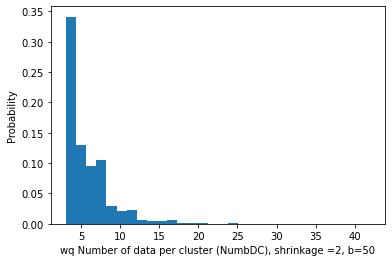

In [16]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
np.random.seed(42)
plt.hist(NumbDC, density=True, bins=30)  # `density=False` would make counts
plt.ylabel('Probability')
plt.xlabel('wq Number of data per cluster (NumbDC), shrinkage =2, b=50');

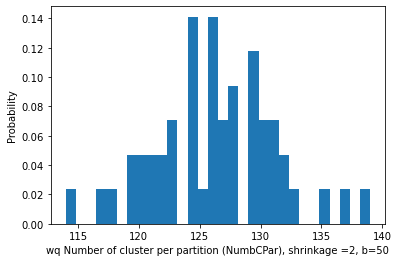

In [17]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
np.random.seed(42)
plt.hist(NumbCPar
         , density=True, bins=30)  # `density=False` would make counts
plt.ylabel('Probability')
plt.xlabel('wq Number of cluster per partition (NumbCPar), shrinkage =2, b=50');

In [ ]:
# Instantiation 
xgb_r = xg.XGBRegressor(objective ='reg:linear', n_estimators = 10, seed = 123) 

scovariables_train = covariables_train.reshape(1, -1)
sresponse_train = response_train.reshape(1, -1)

# Fitting the model 
xgb_r.fit(scovariables_train,sresponse_train) 
  
# Predict the model 
xgtestpred = xgb_r.predict(covariables_test) 
# Predict the model 
xgtrainpred = xgb_r.predict(covariables_train)  
# xgboost test RMSE Computation 
xgtestrmse = np.sqrt(MSE(response_test, xgtestpred)) 
print("test xgboost RMSE : % f" %(xgtestrmse))

# xgboost test RMSE Computation 
xgtrainrmse = np.sqrt(MSE(response_test, testpred)) 
print("train xgboost RMSE : % f" %(xgtrainrmse))

In [18]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xg
from sklearn.metrics import mean_squared_error as MSE
from sklearn.ensemble import RandomForestRegressor

In [38]:

############################################################
regressor = RandomForestRegressor(n_estimators = 10, max_depth=30, random_state = 0)
regressor.fit(covariables_train,response_train) 

# Predict the model 
rftestpred = regressor.predict(covariables_test) 
# Predict the model 
rftrainpred = regressor.predict(covariables_train)  
# xgboost test RMSE Computation 
rftestrmse = MSE(response_test, rftestpred) 
print("test xgboost MSE : % f" %(rftestrmse))

# xgboost test RMSE Computation 
rftrainrmse = MSE(response_train, rftrainpred)
print("train xgboost MSE : % f" %(rftrainrmse))


test xgboost MSE :  1.388110
train xgboost MSE :  0.224989


In [39]:

############################################################
regressor = RandomForestRegressor(n_estimators = 5, max_depth=10, random_state = 0)
regressor.fit(covariables_train,response_train) 

# Predict the model 
rftestpred = regressor.predict(covariables_test) 
# Predict the model 
rftrainpred = regressor.predict(covariables_train)  
# xgboost test RMSE Computation 
rftestrmse = MSE(response_test, rftestpred)
print("test xgboost MSE : % f" %(rftestrmse))

# xgboost test RMSE Computation 
rftrainrmse = MSE(response_train, rftrainpred)
print("train xgboost MSE : % f" %(rftrainrmse))

test xgboost MSE :  1.443956
train xgboost MSE :  0.517390
